In [44]:
# Make sure that you have all these libaries available to run the code successfully
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [45]:
data = pd.read_csv('AAPL_daily.csv')
df = pd.DataFrame(data)

In [46]:
df.set_index("Date", inplace=True)

In [47]:
df[:25]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-02-01,4.865714,4.878214,4.720714,4.776786,4.071817,1010744000
2008-02-04,4.793214,4.853571,4.693571,4.701786,4.007886,899234000
2008-02-05,4.658214,4.785714,4.603571,4.620000,3.938171,1141042000
2008-02-06,4.672500,4.711429,4.348929,4.357143,3.714106,1573272400
2008-02-07,4.284643,4.456429,4.188214,4.330000,3.690970,2083331600
2008-02-08,4.360000,4.489286,4.342857,4.481429,3.820051,1355972800
2008-02-11,4.571786,4.642143,4.542857,4.623214,3.940909,1201432400
2008-02-12,4.667857,4.678571,4.415000,4.459286,3.801176,1225980000
2008-02-13,4.524286,4.635000,4.486786,4.621429,3.939389,968534000


This dataset represents the financial data of every working day during 5 years.

For the LSTM network, we have to segments our dataset into batches of training and test sets. We will train our data on batches of three weeks, so 15 input data. The training set of each batch will consist of 14 input data for the train part, and the last input will be used for the test part.

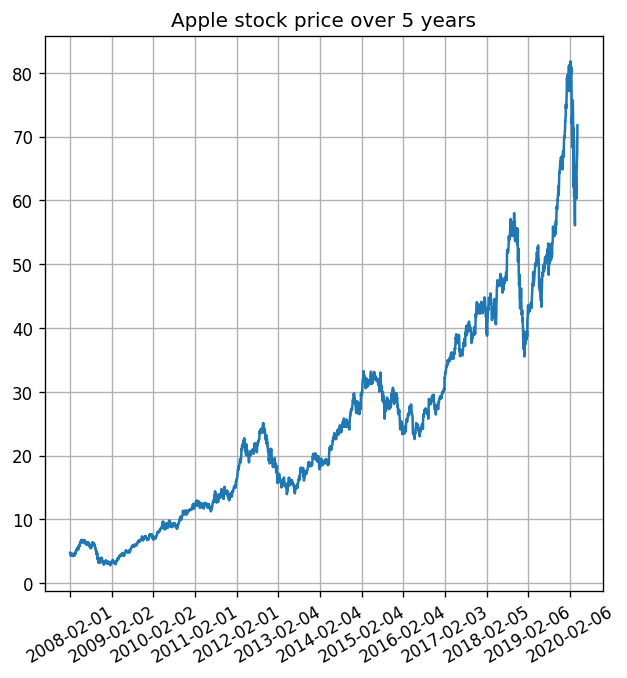

In [48]:
y = df['Close']
plt.figure(figsize=(6, 6))
plt.title('Apple stock price over 5 years')
plt.grid(True)
plt.xticks(np.arange(0, len(y), step=252), rotation=30)
plt.plot(y)
plt.show()

In [49]:
# First calculate the mid prices from the highest and lowest
high_prices = df['High']
low_prices = df['Low']
mid_prices = (high_prices+low_prices) / 2
len(mid_prices)

3071

In [50]:
# Check the stationarity of the model with an ADF
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(mid_prices.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.729867
p-value: 0.990415


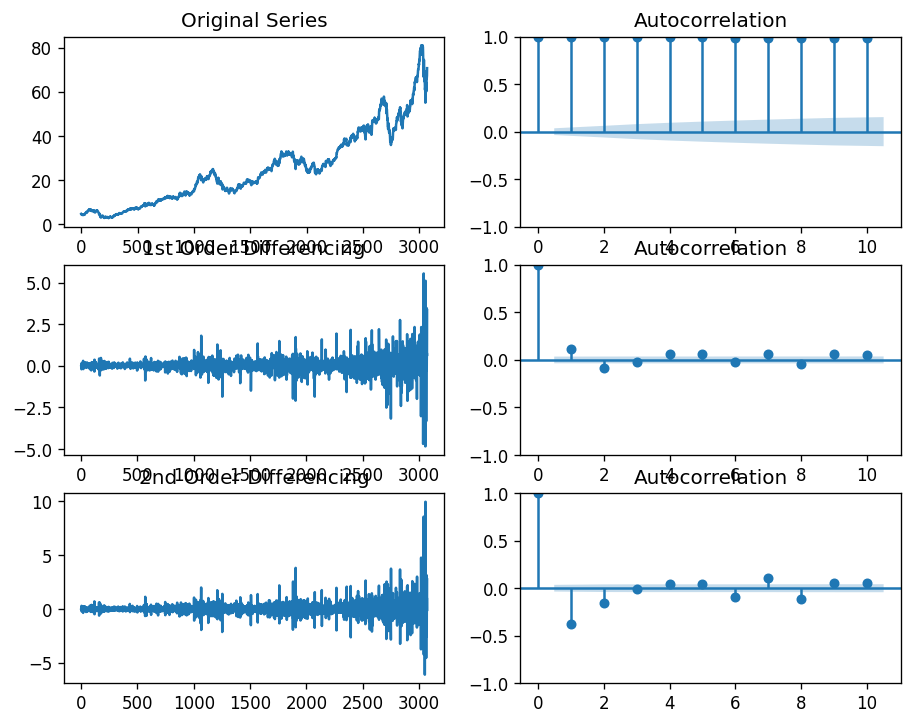

In [51]:
# As the p-value is above 0.05, we will differenciate the serie and check the autocorrelation plot
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
n_lags = 10

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(mid_prices.values); axes[0, 0].set_title('Original Series')
plot_acf(mid_prices.values, ax=axes[0, 1], lags=n_lags)

# 1st Differencing
axes[1, 0].plot(mid_prices.diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_acf(mid_prices.diff().dropna(), ax=axes[1, 1], lags=n_lags)

# 2nd Differencing
axes[2, 0].plot(mid_prices.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(mid_prices.diff().diff().dropna(), ax=axes[2, 1], lags=n_lags)

plt.show()

In [52]:
# Differentiate the signal once, to get the signal stationary
mid_prices = mid_prices.diff().dropna()

In [61]:
# We will keep the last 15 days of the dataset as a training set
n_elems = len(mid_prices)
batch_size = 60
test_size = batch_size * 8
train_data = mid_prices[:-test_size]
test_data = mid_prices[-test_size:]
print(train_data[:5])

Date
2008-02-04   -0.025893
2008-02-05   -0.078929
2008-02-06   -0.164463
2008-02-07   -0.207858
2008-02-08    0.093750
dtype: float64


In [62]:
# Scale the dataset
train_data = train_data.values
train_data = train_data.reshape(n_elems-test_size, 1)
test_data = test_data.values
test_data = test_data.reshape(test_size, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

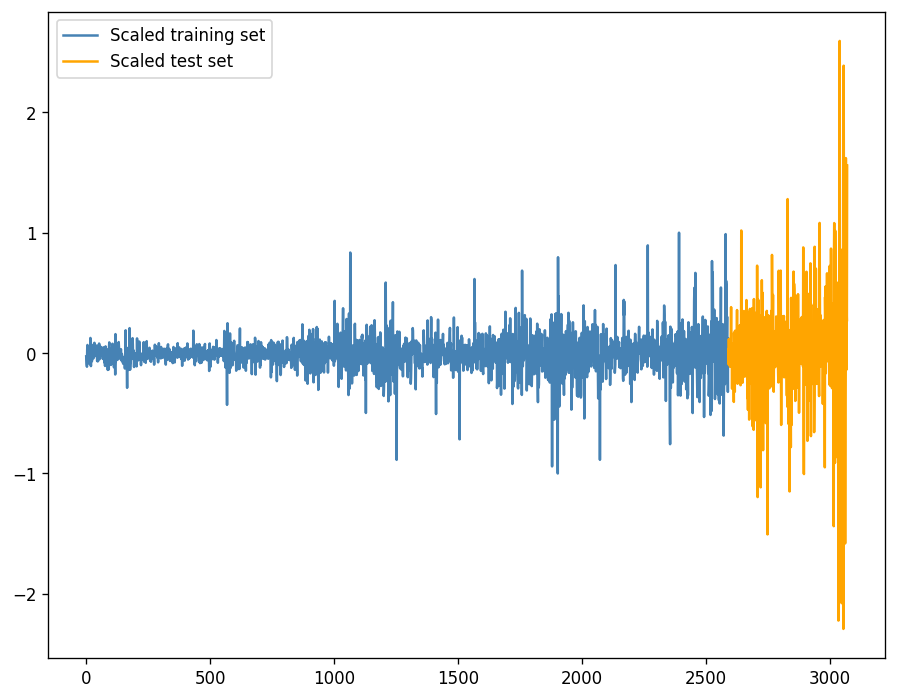

In [63]:
plt.plot(np.arange(len(train_data)), train_data, color='steelblue')
plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), test_data, color='orange')

# you seemed to mess up the labels
plt.legend(['Scaled training set', 'Scaled test set'])
plt.show()

We must now prepare the batches of dataset for the LSTM. These batches will consist of three weeks of data, so 15 input data.

In [64]:
week_lenght = 1
train_X, train_y = [], []
for i in range(0, train_data.shape[0]-batch_size, week_lenght): 
        train_X.append(train_data[i:i+batch_size]) # each training sample is of length input hours
        train_y.append(train_data[i+batch_size][0]) # each y is just the next step after training sample

train_X = np.array(train_X) # format our new training set to keras format
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
train_y = np.array(train_y) # make sure y is an array to work properly with keras
train_X.shape

(2530, 60, 1)

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# fit an LSTM network to training data
def fit_lstm(X, y, batch_size, nb_epochs, neurons):
    # X, y = train[:, 0:-1], train[:, -1]
    # X, y = train
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()

    # model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    # Adding first LSTM layer and some dropout Dropout regularisation
    model.add(LSTM(units=neurons,return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(rate=0.2))

    # Adding second LSTM layer and some dropout Dropout regularisation
    model.add(LSTM(units=neurons,return_sequences=True))
    model.add(Dropout(rate=0.2))

    # Adding third LSTM layer and some dropout Dropout regularisation
    model.add(LSTM(units=neurons,return_sequences=True))
    model.add(Dropout(rate=0.2))

    # Adding fourth LSTM layer and some dropout Dropout regularisation
    model.add(LSTM(units=neurons,return_sequences=True))
    model.add(Dropout(rate=0.2))

    # Adding fifth LSTM layer and some dropout Dropout regularisation
    model.add(LSTM(units=neurons))
    model.add(Dropout(rate=0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epochs, batch_size=batch_size, verbose=0)
    model.summary()
    # for _ in range(nb_epoch):
    #     model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    #     model.reset_states()
    return model

model = fit_lstm(train_X, train_y, batch_size=32, nb_epochs=100, neurons=100)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 1, 100)            64400     
                                                                 
 dropout_20 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_24 (LSTM)              (None, 1, 100)            80400     
                                                                 
 dropout_21 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_25 (LSTM)              (None, 1, 100)            80400     
                                                                 
 dropout_22 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_26 (LSTM)              (None, 1, 100)           

In [115]:
def forecast(model, batch_size, X_test, steps, n_preds):
    # print(X_test)
    X = X_test[:steps].copy().reshape(1,1,-1)
    X_list = X[0][0].tolist()
    preds = []
    
    for i in range(n_preds):
        pred = model.predict(X, batch_size=batch_size)
        X_list.append(X_test[steps+i][0])
        # X_list.append(pred[0][0])
        X_list.pop(0)
        preds.append(pred[0][0])
        # print(X_list[-batch_size:])
        X = np.array(X_list).reshape(1,1,-1) # replace first 11 values with 2nd through 12th
        # X[:,:,:-1] = pred # replace 12th value with prediction
        # print(X)
    return preds

steps = batch_size
n_preds = test_size - batch_size
preds = forecast(model, 1, test_data, steps, n_preds)


In [118]:
# Prepare the data for the plot (unscale it and integrate it)
truth_unscaled = scaler.inverse_transform(test_data)
preds_unscaled = np.array(preds).reshape(-1, 1)
preds_unscaled = scaler.inverse_transform(preds_unscaled)

# Remove the train part of the truth values
start_val = 100
truth_unscaled = truth_unscaled[batch_size:]
truth = np.r_[start_val, truth_unscaled.reshape(-1)].cumsum()
# predictions = np.r_[start_val, preds_unscaled.reshape(-1)].cumsum()

# To build the predictions signal, take the lagged truth values, and add the predicitons of the model to generate the predicted values
predictions = np.vstack((truth.reshape(-1)[:-1], preds_unscaled.reshape(-1)))
predictions = predictions.sum(axis=0)
# predictions
# predictions = np.r_[130, preds_unscaled.reshape(-1)].cumsum()

421
420


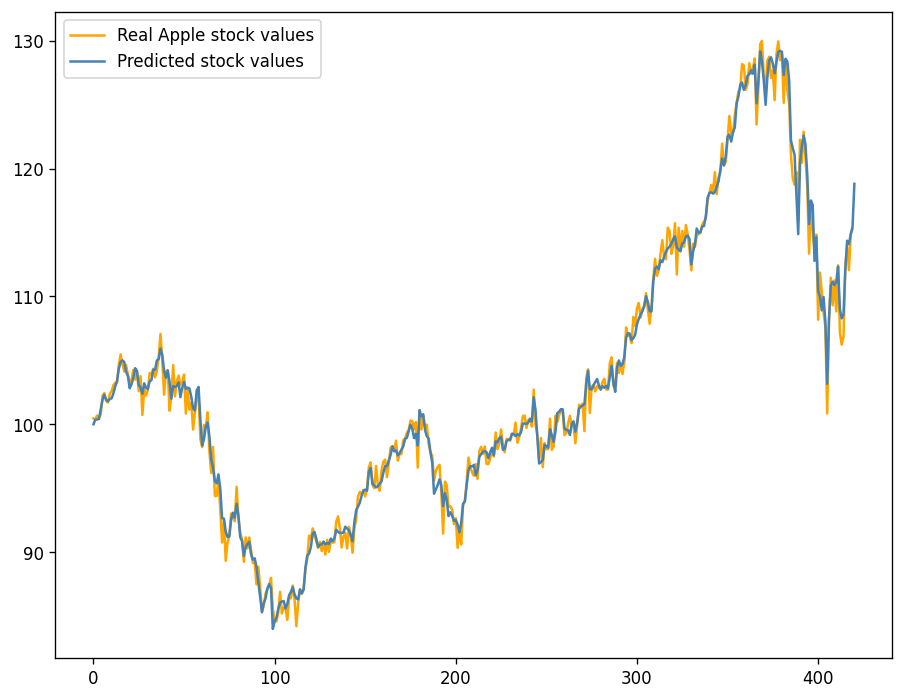

In [121]:
# print(test_data)
# test_list = test_data[0][0].tolist()
print(len(truth))
print(len(predictions))
plt.plot(np.arange(len(predictions)), predictions, color='orange')
plt.plot(np.arange(len(truth)), truth, color='steelblue')
# plt.plot(np.arange(len(mid_prices[-test_size:])), mid_prices[-test_size:], color='green')

# you seemed to mess up the labels
plt.legend(['Real Apple stock values', 'Predicted stock values'])
plt.show()